In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.layers import LSTM,Dropout,Dense,BatchNormalization
from keras.models import Sequential,InputLayer
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sn

In [3]:
from keras.metrics import RootMeanSquaredError as rsme
from keras.callbacks import ModelCheckpoint

In [4]:
cd /content/drive/MyDrive/Electricity load Forecasting

/content/drive/MyDrive/Electricity load Forecasting


In [5]:
data = pd.read_csv("assignment-data.csv")

In [6]:
data.head(10)

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
0,0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,2018-01-01
1,1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,2018-01-01
2,2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,2018-01-01
3,3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,2018-01-01
4,4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,2018-01-01
5,5,2018-01-01 01:15:00,684.37600,9.80175,9.80175,0.986125,8.775375,0.0,0.0,2018-01-01
6,6,2018-01-01 01:30:00,679.37650,9.67050,9.67050,0.992250,8.741250,0.0,0.0,2018-01-01
7,7,2018-01-01 01:45:00,671.21570,9.53925,9.53925,0.998375,8.707125,0.0,0.0,2018-01-01
8,8,2018-01-01 02:00:00,658.39577,9.40800,9.40800,1.004500,8.673000,0.0,0.0,2018-01-01
9,9,2018-01-01 02:15:00,642.95287,9.27675,9.27675,1.010625,8.638875,0.0,0.0,2018-01-01


In [7]:
data.drop(columns=["Unnamed: 0"],inplace = True)

In [8]:
data.drop(columns=["date"] ,inplace = True)
data

,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.000000,0.00000
1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.000000,0.00000
2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.000000,0.00000
3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.000000,0.00000
4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.000000,0.00000
...,...,...,...,...,...,...,...,...
103387,2020-12-12 22:45:00,858.50000,17.79750,17.79750,0.756000,12.400500,1.950375,0.16275
103388,2020-12-12 23:00:00,832.24000,17.66100,17.66100,0.756000,12.264000,2.047500,0.14700
103389,2020-12-12 23:15:00,804.97000,17.46675,17.46675,0.758625,12.127500,2.144625,0.11550
103390,2020-12-12 23:30:00,763.56000,17.27250,17.27250,0.761250,11.991000,2.241750,0.08400


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103392 entries, 0 to 103391
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   datetime              103392 non-null  object 
 1   load                  101952 non-null  float64
 2   apparent_temperature  103392 non-null  float64
 3   temperature           103392 non-null  float64
 4   humidity              103392 non-null  float64
 5   dew_point             103392 non-null  float64
 6   wind_speed            103392 non-null  float64
 7   cloud_cover           103392 non-null  float64
dtypes: float64(7), object(1)
memory usage: 6.3+ MB


In [10]:
data.isnull().sum()

datetime                   0
load                    1440
apparent_temperature       0
temperature                0
humidity                   0
dew_point                  0
wind_speed                 0
cloud_cover                0
dtype: int64

In [11]:
data["load"] = data["load"].interpolate(method="linear" ,limit_direction="both" ,limit_area="inside")

In [12]:
data.isnull().sum()

datetime                0
load                    0
apparent_temperature    0
temperature             0
humidity                0
dew_point               0
wind_speed              0
cloud_cover             0
dtype: int64

# Preparing data for Training

In [13]:
train_date = pd.to_datetime(data["datetime"])
train_date

0        2018-01-01 00:00:00
1        2018-01-01 00:15:00
2        2018-01-01 00:30:00
3        2018-01-01 00:45:00
4        2018-01-01 01:00:00
                 ...        
103387   2020-12-12 22:45:00
103388   2020-12-12 23:00:00
103389   2020-12-12 23:15:00
103390   2020-12-12 23:30:00
103391   2020-12-12 23:45:00
Name: datetime, Length: 103392, dtype: datetime64[ns]

In [14]:
len(train_date)

103392

In [15]:
cols = list(data)[1:]
cols

['load',
 'apparent_temperature',
 'temperature',
 'humidity',
 'dew_point',
 'wind_speed',
 'cloud_cover']

In [16]:
training_data = data[cols].astype(float)
training_data

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,803.22270,10.45800,10.45800,0.955500,8.946000,0.000000,0.00000
1,774.89523,10.32675,10.32675,0.961625,8.911875,0.000000,0.00000
2,731.46927,10.19550,10.19550,0.967750,8.877750,0.000000,0.00000
3,713.93870,10.06425,10.06425,0.973875,8.843625,0.000000,0.00000
4,699.23007,9.93300,9.93300,0.980000,8.809500,0.000000,0.00000
...,...,...,...,...,...,...,...
103387,858.50000,17.79750,17.79750,0.756000,12.400500,1.950375,0.16275
103388,832.24000,17.66100,17.66100,0.756000,12.264000,2.047500,0.14700
103389,804.97000,17.46675,17.46675,0.758625,12.127500,2.144625,0.11550
103390,763.56000,17.27250,17.27250,0.761250,11.991000,2.241750,0.08400


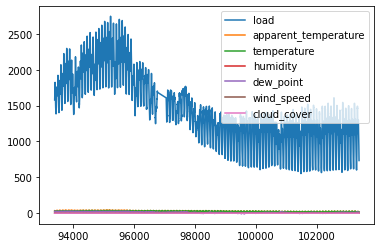

In [17]:
training_data.tail(10000).plot.line()

In [18]:
scaler = StandardScaler()
scaler = scaler.fit_transform(training_data)

In [19]:
training_features = []
training_labels = []

In [20]:
n_future = 1
n_past = 14

In [21]:
for i in range(n_past, len(training_data) - n_future + 1):
    training_features.append(scaler[i - n_past :i -1 ,0:training_data.shape[1]])
    
    training_labels.append(scaler[i + n_future - 1:i + n_future,0])

In [22]:
training_features , training_labels = np.array(training_features) ,np.array(training_labels)

In [23]:
training_features.shape

(103378, 13, 7)

In [24]:
training_labels.shape

(103378, 1)

# LSTM Model

In [25]:
def model():
    model = Sequential()
    model.add(LSTM(units =128,activation = "relu",input_shape= (training_features.shape[1], training_features.shape[2]),
                  return_sequences = True))
    model.add(LSTM(units = 64 ,activation = "relu", return_sequences = False))
    model.add(Dropout(0.4))
    model.add(Dense(1 ,activation ="relu"))
    return model

In [26]:
network  =model()

In [27]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 128)           69632     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 119,105
Trainable params: 119,105
Non-trainable params: 0
_________________________________________________________________


In [30]:
network.compile(optimizer="adam" ,loss = "mse",metrics =["mae",rsme()])

In [31]:
network.fit(x = training_features,y = training_labels, verbose= 1, validation_split=0.2, shuffle=False,epochs = 20,
            callbacks = ModelCheckpoint("/content/drive/MyDrive/Electricity load Forecasting/ckpt",
                                        monitor="mae",save_best_only=True,mode ="min"))

Epoch 1/20
2585/2585 [==============================] - ETA: 0s - loss: 0.5941 - mae: 0.5866 - root_mean_squared_error: 0.7708INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 132s 50ms/step - loss: 0.5941 - mae: 0.5866 - root_mean_squared_error: 0.7708 - val_loss: 0.4031 - val_mae: 0.4900 - val_root_mean_squared_error: 0.6349
Epoch 2/20
2585/2585 [==============================] - ETA: 0s - loss: 0.5114 - mae: 0.5093 - root_mean_squared_error: 0.7151INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.5114 - mae: 0.5093 - root_mean_squared_error: 0.7151 - val_loss: 0.3220 - val_mae: 0.3823 - val_root_mean_squared_error: 0.5675
Epoch 3/20
2585/2585 [==============================] - ETA: 0s - loss: 0.5037 - mae: 0.4923 - root_mean_squared_error: 0.7097INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.5037 - mae: 0.4923 - root_mean_squared_error: 0.7097 - val_loss: 0.3097 - val_mae: 0.3505 - val_root_mean_squared_error: 0.5565
Epoch 4/20
2585/2585 [==============================] - ETA: 0s - loss: 0.5019 - mae: 0.4887 - root_mean_squared_error: 0.7085INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.5019 - mae: 0.4887 - root_mean_squared_error: 0.7085 - val_loss: 0.3053 - val_mae: 0.3384 - val_root_mean_squared_error: 0.5526
Epoch 5/20
2584/2585 [============================>.] - ETA: 0s - loss: 0.5005 - mae: 0.4858 - root_mean_squared_error: 0.7075INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.5005 - mae: 0.4859 - root_mean_squared_error: 0.7075 - val_loss: 0.3049 - val_mae: 0.3365 - val_root_mean_squared_error: 0.5522
Epoch 6/20
2584/2585 [============================>.] - ETA: 0s - loss: 0.4999 - mae: 0.4844 - root_mean_squared_error: 0.7070INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.4999 - mae: 0.4845 - root_mean_squared_error: 0.7070 - val_loss: 0.3041 - val_mae: 0.3344 - val_root_mean_squared_error: 0.5515
Epoch 7/20
2584/2585 [============================>.] - ETA: 0s - loss: 0.4998 - mae: 0.4843 - root_mean_squared_error: 0.7070INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.4998 - mae: 0.4844 - root_mean_squared_error: 0.7070 - val_loss: 0.3035 - val_mae: 0.3304 - val_root_mean_squared_error: 0.5509
Epoch 8/20
2585/2585 [==============================] - ETA: 0s - loss: 0.4993 - mae: 0.4829 - root_mean_squared_error: 0.7066INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.4993 - mae: 0.4829 - root_mean_squared_error: 0.7066 - val_loss: 0.3045 - val_mae: 0.3373 - val_root_mean_squared_error: 0.5518
Epoch 9/20
2585/2585 [==============================] - 113s 44ms/step - loss: 0.4993 - mae: 0.4829 - root_mean_squared_error: 0.7066 - val_loss: 0.3047 - val_mae: 0.3353 - val_root_mean_squared_error: 0.5520
Epoch 10/20
2585/2585 [==============================] - 113s 44ms/step - loss: 0.4994 - mae: 0.4831 - root_mean_squared_error: 0.7067 - val_loss: 0.3021 - val_mae: 0.3260 - val_root_mean_squared_error: 0.5496
Epoch 11/20
2585/2585 [==============================] - ETA: 0s - loss: 0.4991 - mae: 0.4823 - root_mean_squared_error: 0.7065INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 115s 45ms/step - loss: 0.4991 - mae: 0.4823 - root_mean_squared_error: 0.7065 - val_loss: 0.3030 - val_mae: 0.3307 - val_root_mean_squared_error: 0.5505
Epoch 12/20
2585/2585 [==============================] - 113s 44ms/step - loss: 0.4992 - mae: 0.4824 - root_mean_squared_error: 0.7065 - val_loss: 0.3038 - val_mae: 0.3332 - val_root_mean_squared_error: 0.5512
Epoch 13/20
2585/2585 [==============================] - 113s 44ms/step - loss: 0.4993 - mae: 0.4825 - root_mean_squared_error: 0.7066 - val_loss: 0.3071 - val_mae: 0.3476 - val_root_mean_squared_error: 0.5542
Epoch 14/20
2585/2585 [==============================] - 113s 44ms/step - loss: 0.4992 - mae: 0.4825 - root_mean_squared_error: 0.7066 - val_loss: 0.3038 - val_mae: 0.3345 - val_root_mean_squared_error: 0.5511
Epoch 15/20
2585/2585 [==============================] - ETA: 0s - loss: 0.4990 - mae: 0.4820 - root_mean_squared_error: 0.7064INFO:tensorflow:Assets written to: /content/d

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.4990 - mae: 0.4820 - root_mean_squared_error: 0.7064 - val_loss: 0.3030 - val_mae: 0.3302 - val_root_mean_squared_error: 0.5504
Epoch 16/20
2585/2585 [==============================] - ETA: 0s - loss: 0.4990 - mae: 0.4820 - root_mean_squared_error: 0.7064INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 115s 45ms/step - loss: 0.4990 - mae: 0.4820 - root_mean_squared_error: 0.7064 - val_loss: 0.3040 - val_mae: 0.3354 - val_root_mean_squared_error: 0.5514
Epoch 17/20
2585/2585 [==============================] - 113s 44ms/step - loss: 0.4991 - mae: 0.4821 - root_mean_squared_error: 0.7064 - val_loss: 0.3045 - val_mae: 0.3366 - val_root_mean_squared_error: 0.5518
Epoch 18/20
2584/2585 [============================>.] - ETA: 0s - loss: 0.4989 - mae: 0.4818 - root_mean_squared_error: 0.7064INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 115s 45ms/step - loss: 0.4989 - mae: 0.4819 - root_mean_squared_error: 0.7063 - val_loss: 0.3059 - val_mae: 0.3427 - val_root_mean_squared_error: 0.5531
Epoch 19/20
2585/2585 [==============================] - 113s 44ms/step - loss: 0.5006 - mae: 0.4822 - root_mean_squared_error: 0.7075 - val_loss: 0.3155 - val_mae: 0.3742 - val_root_mean_squared_error: 0.5617
Epoch 20/20
2585/2585 [==============================] - ETA: 0s - loss: 0.4989 - mae: 0.4816 - root_mean_squared_error: 0.7064INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Electricity load Forecasting/ckpt/assets


2585/2585 [==============================] - 116s 45ms/step - loss: 0.4989 - mae: 0.4816 - root_mean_squared_error: 0.7064 - val_loss: 0.3067 - val_mae: 0.3460 - val_root_mean_squared_error: 0.5538
